In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from PIL import Image
from torch import nn, Tensor
import torch.nn.functional as F
import math
from typing import Tuple
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from simpletransformers.classification import ClassificationModel, ClassificationArgs
import pandas as pd
import logging

import vit
from helper import *

c:\programdata\miniconda3\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
USE_CUDA = True

In [3]:
if torch.cuda.is_available() and USE_CUDA == True:
    device = torch.device("cuda:0")
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


In [4]:
train = geneDataset("train")
test = geneDataset("test")

In [5]:
trainset = torch.utils.data.DataLoader(train, batch_size=40, shuffle=True)
testset = torch.utils.data.DataLoader(test, batch_size=40, shuffle=True)

In [6]:
import gc

try:
    del net
    del X
    del y
    
except:
    print("variable not yet declared")

gc.collect()

variable not yet declared


0

In [7]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x.type(torch.FloatTensor)


In [8]:
# net = vit.VisionTransformer()
net = Net()
net.to(device)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)

In [9]:
total_params = sum(p.numel() for p in net.parameters())
print(total_params)

61026


In [10]:
loss_function = torch.nn.L1Loss()

In [11]:
def getTestLoss():
    loss = 0
    
    for data in testset:
        X, y = data
        X = X.to(device)

        output = net(X)
        loss += loss_function(output, y)
    
    return(loss)

In [12]:
pos = 0
neg = 0

def getAccuracy(net):
    wrong = 0
    right = 0
    total = 0

    with torch.no_grad():
        for data in testset:
            X, y = data

            X = X.to(device)
            y = y.to(device)

            output = net(X)

            for i in range(len(output)):
                if y[i][0] == round(float(output[i][0])):
                    right += 1
                else:
                    wrong += 1

                total += 1

    return (right / total)

In [13]:
import torch.optim as optim

optimizer = optim.Adam(net.parameters(), lr=0.0005)

In [14]:
trainloss = []
testloss = []

In [15]:
EPOCHS = 15
count = 0

lowestLoss = 0
lowestNet = 0

In [16]:
for epoch in range(EPOCHS):    
    for data in trainset:
        X, y = data
        X = X.to(device)

        net.zero_grad()
        output = net(X)
        loss = loss_function(output, y)
        loss.backward()
        optimizer.step()
        
    count += 1 

    print(f"{round((count * 100 / EPOCHS), 2)}% Completed")

    trainloss.append(float(loss))

    testLoss = getAccuracy(net)
    testloss.append(testLoss)

    if testLoss > lowestLoss:
        lowestLoss = testLoss
        lowestNet = epoch

    # torch.save(net, f"nets/net{epoch}.pt")


print("100% Completed")

c:\programdata\miniconda3\lib\site-packages\torch\nn\modules\loss.py:96: UserWarning: Using a target size (torch.Size([40, 1])) that is different to the input size (torch.Size([40, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
c:\programdata\miniconda3\lib\site-packages\torch\nn\modules\loss.py:96: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


6.67% Completed
13.33% Completed
20.0% Completed
26.67% Completed
33.33% Completed
40.0% Completed
46.67% Completed
53.33% Completed
60.0% Completed
66.67% Completed
73.33% Completed
80.0% Completed
86.67% Completed
93.33% Completed
100.0% Completed
100% Completed


In [17]:
print(lowestNet)

9


In [18]:
# lowestNet = 99

In [19]:
# net = torch.load(f"nets/net{lowestNet}.pt")

In [20]:
pos = 0
neg = 0


wrong = 0
right = 0
total = 0

with torch.no_grad():
    for data in testset:
        X, y = data

        X = X.to(device)
        y = y.to(device)

        output = net(X)

        for i in range(len(output)):
            if y[i][0] == round(float(output[i][0])):
                right += 1
            else:
                wrong += 1

            total += 1

print(right / total)

0.7842105263157895


In [21]:
RES = 1000

In [22]:
falsePos = [0] * RES
truePos = [0] * RES
falseNeg = [0] * RES
trueNeg = [0] * RES

In [23]:
count = 0

with torch.no_grad():
    for data in testset:
        X, y = data
        
        X = X.to(device)
        y = y.to(device)

        output = net(X)
        
        for i in range(RES):
            loss = wrongAns(output, y, 2 * i / (RES - 1) - 0.5)
            truePos[i] += loss[0]
            falsePos[i] += loss[1]
            trueNeg[i] += loss[2]
            falseNeg[i] += loss[3]
        
        count += 1
        
        if count % 1 == 0:
            print(f"{round(count * 100 / len(testset), 2)}% Completed")

20.0% Completed
40.0% Completed
60.0% Completed
80.0% Completed
100.0% Completed


Accuracy: 0.8526315789473684
258


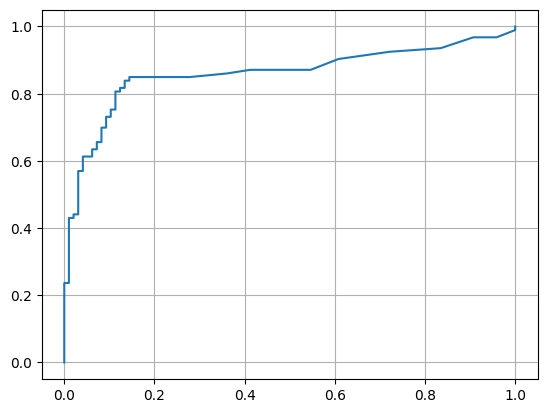

In [24]:
hAcu = 0

falsePosRate = []
truePosRate = []

for i in range(len(truePos)):
    falsePosRate.append(falsePos[i] / (falsePos[i] + trueNeg[i]))
    truePosRate.append(truePos[i] / (truePos[i] + falseNeg[i]))

for i in range(RES):
    if hAcu < truePos[i] + trueNeg[i]:
        hAcu = truePos[i] + trueNeg[i]
        lowestIndex = i

print(f"Accuracy: {(truePos[lowestIndex] + trueNeg[lowestIndex]) / (falsePos[0] + falseNeg[0] + truePos[0] + trueNeg[0])}")
print(lowestIndex)
    
plt.plot(falsePosRate, truePosRate)
plt.grid()

In [25]:
import sklearn.metrics

auc = sklearn.metrics.auc(falsePosRate, truePosRate)

print(auc)

0.8597162177142224


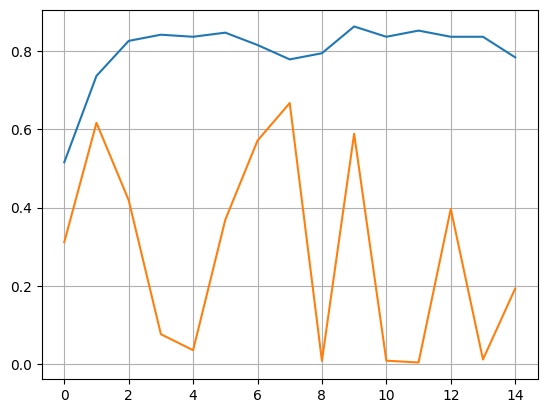

In [26]:
plt.plot(testloss)
plt.plot(trainloss)
plt.grid()

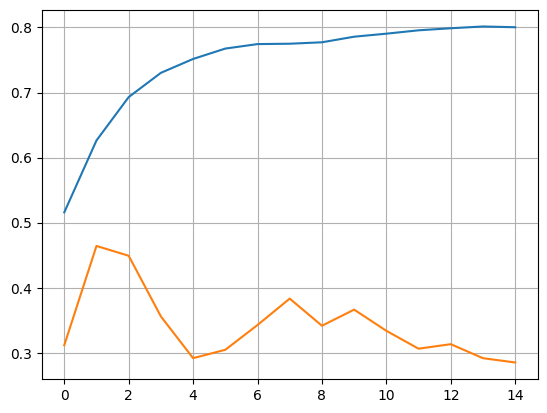

In [27]:
avgTrainLoss = getAvgLoss(trainloss)
avgTestLoss = getAvgLoss(testloss)

plt.plot(avgTestLoss)
plt.plot(avgTrainLoss)
plt.grid()

In [28]:
data = iter(testset)

tensor([1.], device='cuda:0')


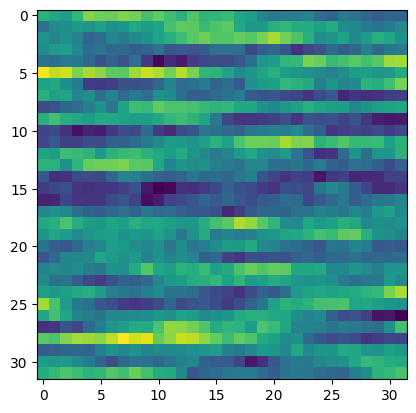

In [29]:
X, y = data.next()

X = X.to(device)
y = y.to(device)
        
output = net(X)

print(y[0])
plt.imshow(X[0].view((32, 32)).cpu())

In [30]:
i = 0

tensor([1.], device='cuda:0')
tensor([0.2000, 0.1785], grad_fn=<SelectBackward0>)


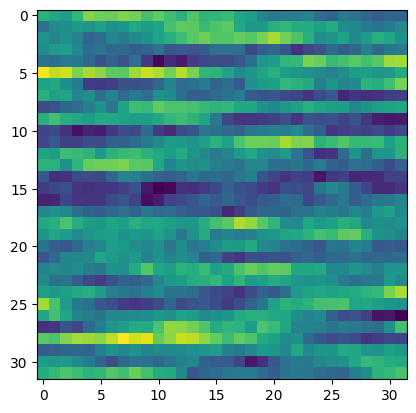

In [31]:
print(y[i])
print(output[i])
plt.imshow(X[i].view((32, 32)).cpu())

i += 1
i %= 20

In [32]:
print(y.view(-1))

tensor([1., 1., 0., 1., 0., 1., 1., 1., 0., 0., 1., 1., 1., 0., 1., 1., 0., 0.,
        1., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1.,
        1., 0., 0., 1.], device='cuda:0')


In [33]:
print(output.view(-1))


tensor([ 1.9998e-01,  1.7846e-01,  1.8397e-01,  1.6194e-01, -1.1997e-02,
        -1.0606e-02, -1.1883e-02, -7.6938e-03, -5.5219e-03, -6.7478e-03,
         1.0762e+00,  1.0562e+00,  9.1848e-01,  8.9136e-01,  7.3190e-01,
         7.0872e-01,  7.2708e-03,  1.4435e-02, -1.6676e-03, -4.4173e-03,
         3.1729e-01,  2.9490e-01,  1.7183e-01,  1.4776e-01,  9.0486e-01,
         8.7448e-01, -1.0527e-02, -1.4372e-02,  8.2332e-01,  7.9010e-01,
         6.3374e-01,  6.1321e-01,  1.2382e-04,  4.8968e-03, -5.1535e-03,
         4.9615e-05,  1.0293e+00,  1.0059e+00, -2.9989e-03,  1.9601e-03,
         7.5797e-02,  5.4505e-02, -3.0524e-03, -8.5601e-04,  1.9773e-01,
         1.8007e-01, -8.5314e-04,  7.5912e-03,  8.6913e-04, -3.5438e-03,
         1.0118e+00,  9.8537e-01,  1.0756e-02,  2.2904e-02,  9.6377e-01,
         9.4286e-01,  6.4591e-03,  1.1506e-02, -4.1008e-03, -1.7557e-03,
        -8.7079e-03, -4.2188e-03, -1.5459e-03, -4.1749e-04,  1.0395e-02,
         2.0560e-02, -8.9558e-03, -5.3995e-03,  8.9

In [34]:
print(X)

tensor([[[[ 1.2368,  1.1839,  1.1434,  ...,  0.8672,  0.9017,  0.8890],
          [ 0.9524,  1.0685,  1.0841,  ...,  0.9711,  0.9950,  1.0569],
          [ 1.1092,  1.0412,  1.0914,  ...,  1.2176,  1.1878,  1.0922],
          ...,
          [ 0.8732,  0.8881,  0.9170,  ...,  1.0976,  1.1586,  1.1082],
          [ 1.1420,  1.1143,  1.1297,  ...,  1.2424,  1.2080,  1.1924],
          [ 1.2076,  1.2560,  1.3147,  ...,  1.2365,  1.2572,  1.3024]]],


        [[[ 0.9203,  1.2087,  1.2643,  ...,  0.9907,  0.9978,  1.0426],
          [ 1.0802,  1.0166,  1.0121,  ...,  0.8769,  0.9454,  1.0164],
          [ 0.9718,  1.0531,  1.0720,  ...,  0.9551,  1.0023,  1.0713],
          ...,
          [ 0.9788,  0.9607,  1.0282,  ...,  1.0897,  1.0497,  0.8496],
          [ 0.9357,  0.8482,  0.8101,  ...,  1.1095,  1.1459,  1.0597],
          [ 1.0747,  1.0683,  1.1124,  ...,  0.9134,  0.8802,  0.9275]]],


        [[[ 0.5688,  0.5226,  0.4980,  ...,  1.1730,  1.0572,  1.1070],
          [ 1.2056,  1.391

In [35]:
def wrongAns(output, expected, threshold):
    falseNeg = 0
    trueNeg = 0
    falsePos = 0
    truePos = 0
    total = 0
    
    for i in range(len(output)):
        if int(expected[i][0]) > 0.5:
            if float(output[i][0]) < threshold:
                falseNeg += 1
            
            else:
                truePos += 1
        else:
            if float(output[i][0]) >= threshold:
                falsePos += 1
                
            else:
                trueNeg += 1

        total += 1
    
    return(truePos, falsePos, trueNeg, falseNeg)